In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic - ML from Disaster

This is an open kaggle called [Titcanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic). This dataset is about predicting the survivors of the titanic. We will either use 0 for did not survive or 1 for surviving the sinking ship. In this notebook we'll explore the data (both test and train), followed by using several supervised models to find the best model for the data.

# Exploratory Data Analysis (EDA)

Firstly, let's understand the data we've been given. Let's explore and check how many features we have and how the data looks.


In [3]:
import pandas as pd

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')

print("Training data")
print("Number of entries: ", df_train.size / df_train.columns.size)
print("Shape: ", df_train.shape)
print("Features: ", df_train.columns)

df_train.head()

Training data
Number of entries:  891.0
Shape:  (891, 12)
Features:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

print("Test data")
print("Number of entries: ", df_test.size / df_test.columns.size)
print("Shape: ", df_test.shape)
print("Features: ", df_test.columns)

df_test.head()

Test data
Number of entries:  418.0
Shape:  (418, 11)
Features:  Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


So, for our train dataset, we have 819 rows and 12 features. However, not all of these will be relevant. In the test dataset we have 418 rows and 11 features (without survived). 

Let's look more closely at how Pclass (Ticket class), sex, age, sibling and/or spouse, parent and/or children, and embarked are distributed. We'll also see if we have any null values and look to tidy up the data if possible.

Unique Classes:  3


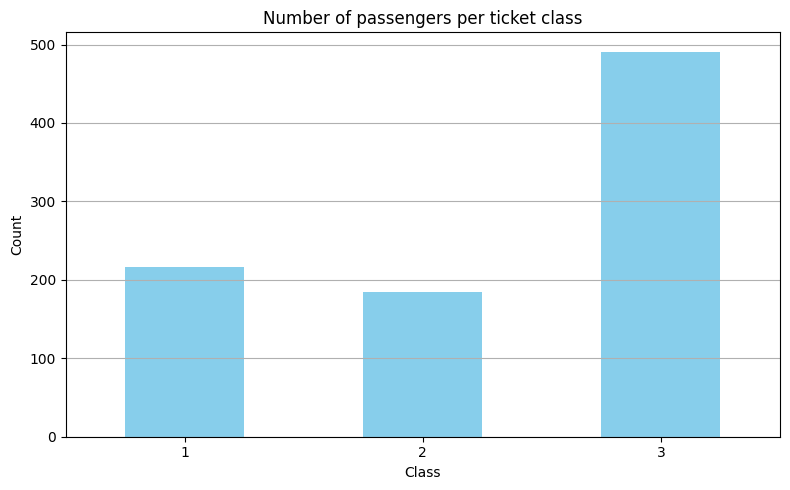

In [6]:
import matplotlib.pyplot as plt

print("Unique Classes: ", df_train['Pclass'].nunique())

class_counts = df_train['Pclass'].value_counts().sort_index()
class_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Number of passengers per ticket class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We can clearly see that there are more people in the 3rd class of the tickets. However, the distribution is not completely lopsided, so it should be ok for most models.

Unique Survived:  2


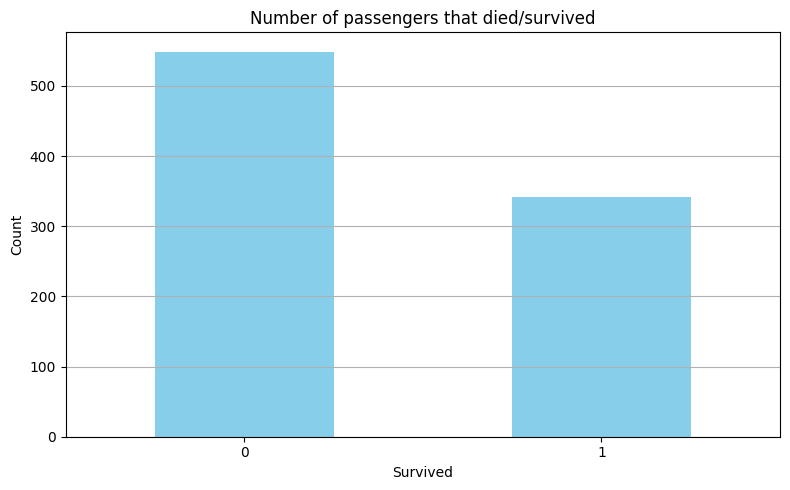

In [2]:
import matplotlib.pyplot as plt

print("Unique Survived: ", df_train['Survived'].nunique())

class_counts = df_train['Survived'].value_counts().sort_index()
class_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Number of passengers that died/survived")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

We can see we have a not-so-different survival rate. The distribution should be ok for most models.

Gender:  2


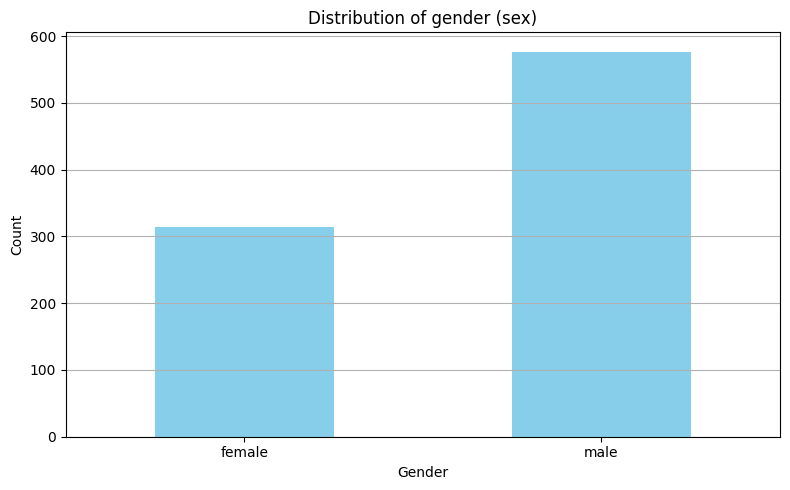

In [7]:
import matplotlib.pyplot as plt

print("Gender: ", df_train['Sex'].nunique())

gender_counts = df_train['Sex'].value_counts().sort_index()
gender_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Distribution of gender (sex)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Ok, so we only have male and female. There are almost twice as many males than females. Still, it's not completely lopsided so it should be ok for most models.

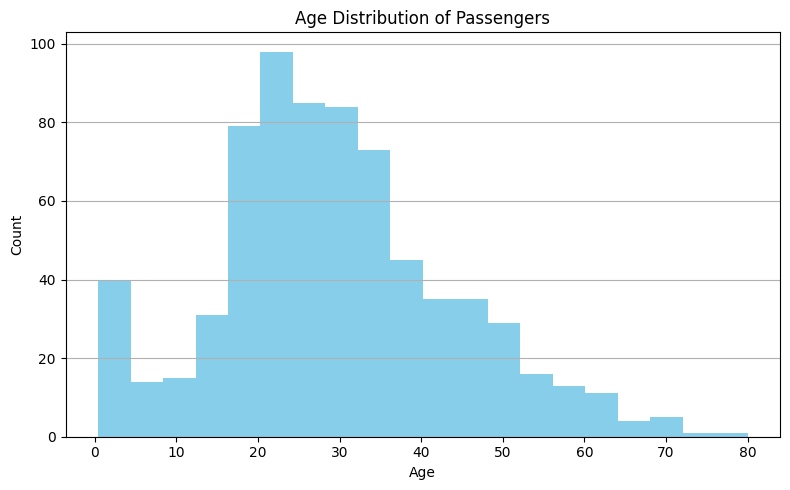

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_train['Age'].dropna().plot(kind='hist', bins=20, color='skyblue')

plt.title("Age Distribution of Passengers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

It looks as if most people are in between 18 to 40 years old. This is a pretty good distribution.

Unique Sibling / Spouse relationships:  7


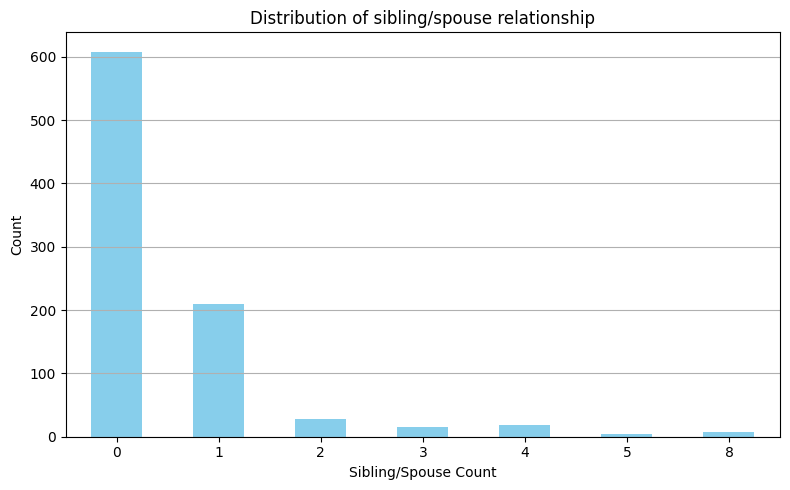

In [9]:
import matplotlib.pyplot as plt

print("Unique Sibling / Spouse relationships: ", df_train['SibSp'].nunique())

class_counts = df_train['SibSp'].value_counts().sort_index()
class_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Distribution of sibling/spouse relationship")
plt.xlabel("Sibling/Spouse Count")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

It looks as if most of the people do not have a sibling or spouse present on board. Based on this, the feature might not be so relevant to survival as most people have 0.

Unique Parent / Child relationships:  7


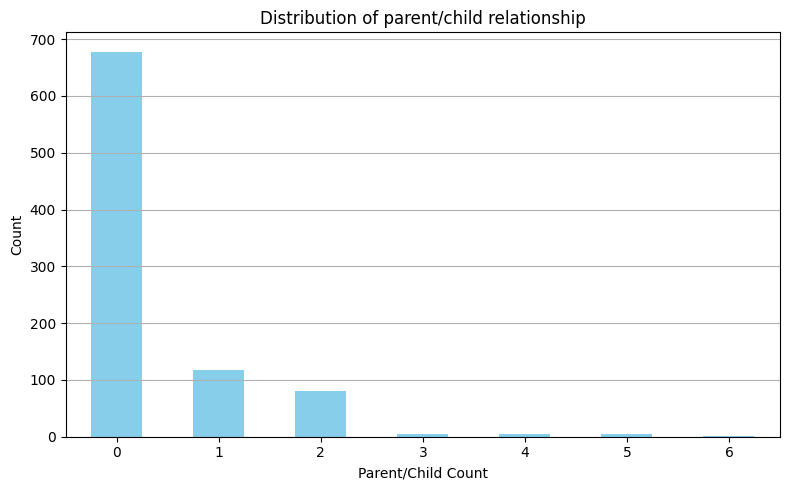

In [10]:
import matplotlib.pyplot as plt

print("Unique Parent / Child relationships: ", df_train['Parch'].nunique())

class_counts = df_train['Parch'].value_counts().sort_index()
class_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Distribution of parent/child relationship")
plt.xlabel("Parent/Child Count")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Again, it looks as if most people did not have a parent or child relationship on board. Again, similar to the last distribution, it may not be so relevant to survival as most people have 0.

Unique Port Embarking:  3


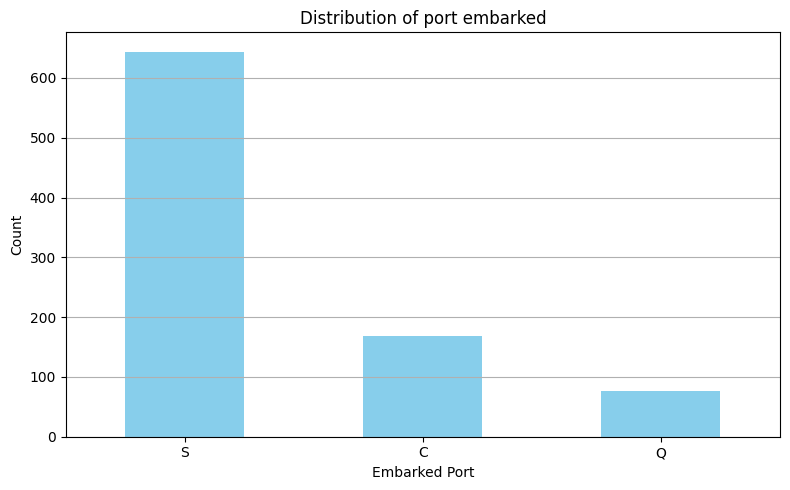

In [11]:
import matplotlib.pyplot as plt

print("Unique Port Embarking: ", df_train['Embarked'].nunique())

df_train['Embarked'].value_counts().plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Distribution of port embarked")
plt.xlabel("Embarked Port")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Ok, looks as if most embarked from the port S (Southampton). I'm not sure if this will be relevant to the survival rate.

But now we want to understand - are all the features important? Let's do a heatmap to help us determine the coorelation between features. 

**Before that, we need to clean the data.**

* I will remove PassengerId as that's not really relevant.
* Name is not something that will be relevant to whether someone survives.
* Ticket is not data that would be relevant
* And Cabin is too hard to encode into something relevant.

We'll transform any missing age details into the median for age using a Simple Imputer.

Next we need to pre-process data to make it easier for the machine learning algorithms to understand. We'll convert gender into labels and we'll convert embarked into labels.

In [109]:
df_train_clean = df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [110]:
from sklearn.impute import SimpleImputer

columns_to_impute = ['Age', 'Fare']

imputer = SimpleImputer(strategy='median')
df_train_clean[columns_to_impute] = imputer.fit_transform(df_train_clean[columns_to_impute])

In [111]:
from sklearn.preprocessing import LabelEncoder

le_sex = LabelEncoder()
le_embarked = LabelEncoder()
df_train_clean['Sex'] = le_sex.fit_transform(df_train_clean['Sex'])
df_train_clean['Embarked'] = le_embarked.fit_transform(df_train_clean['Embarked'])

df_train_clean.shape

(891, 8)

Let's apply the same transformations to the test data.

In [112]:
df_test_clean = df_test.drop(columns=['Cabin', 'Name', 'PassengerId', 'Ticket'])
df_test_clean['Sex'] = le_sex.transform(df_test_clean['Sex'])
df_test_clean['Embarked'] = le_embarked.transform(df_test_clean['Embarked'])
df_test_clean[columns_to_impute] = imputer.transform(df_test_clean[columns_to_impute])

In [113]:
df_train_clean.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,-0.163517
Pclass,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,0.157112
Sex,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,0.104057
Age,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,-0.014205
SibSp,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,0.066654
Parch,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,0.038322
Fare,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,-0.221226
Embarked,-0.163517,0.157112,0.104057,-0.014205,0.066654,0.038322,-0.221226,1.000000


From here, we can see that Sex is highest correlated with survived, followed by Pclass. Fare and Pclass are also highly correlated.

As predicted, SibSp and Parch aren't that relevant to survival (-0.035 and 0.082). What's interesting is that age isn't that relevant at -0.065 whereas the embarked port is more relevant at -0.164.

Following the correlation matrix, let's create a heatmap of the correlation data.

<Axes: >

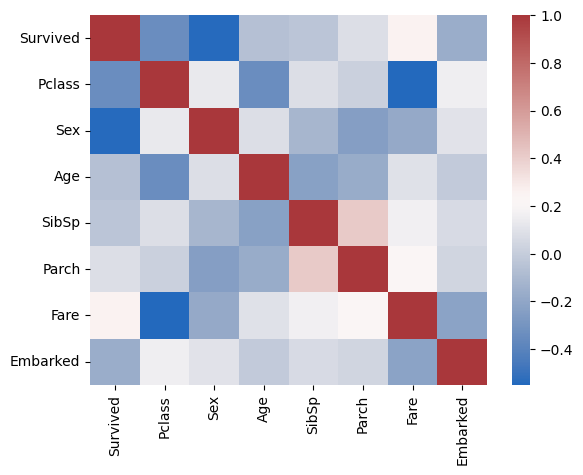

In [114]:
import seaborn as sns

sns.heatmap(data=df_train_clean.corr(), cmap="vlag")

Now, one last visualization for how the data is correlated - the pairplot with kde on the diagonal.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

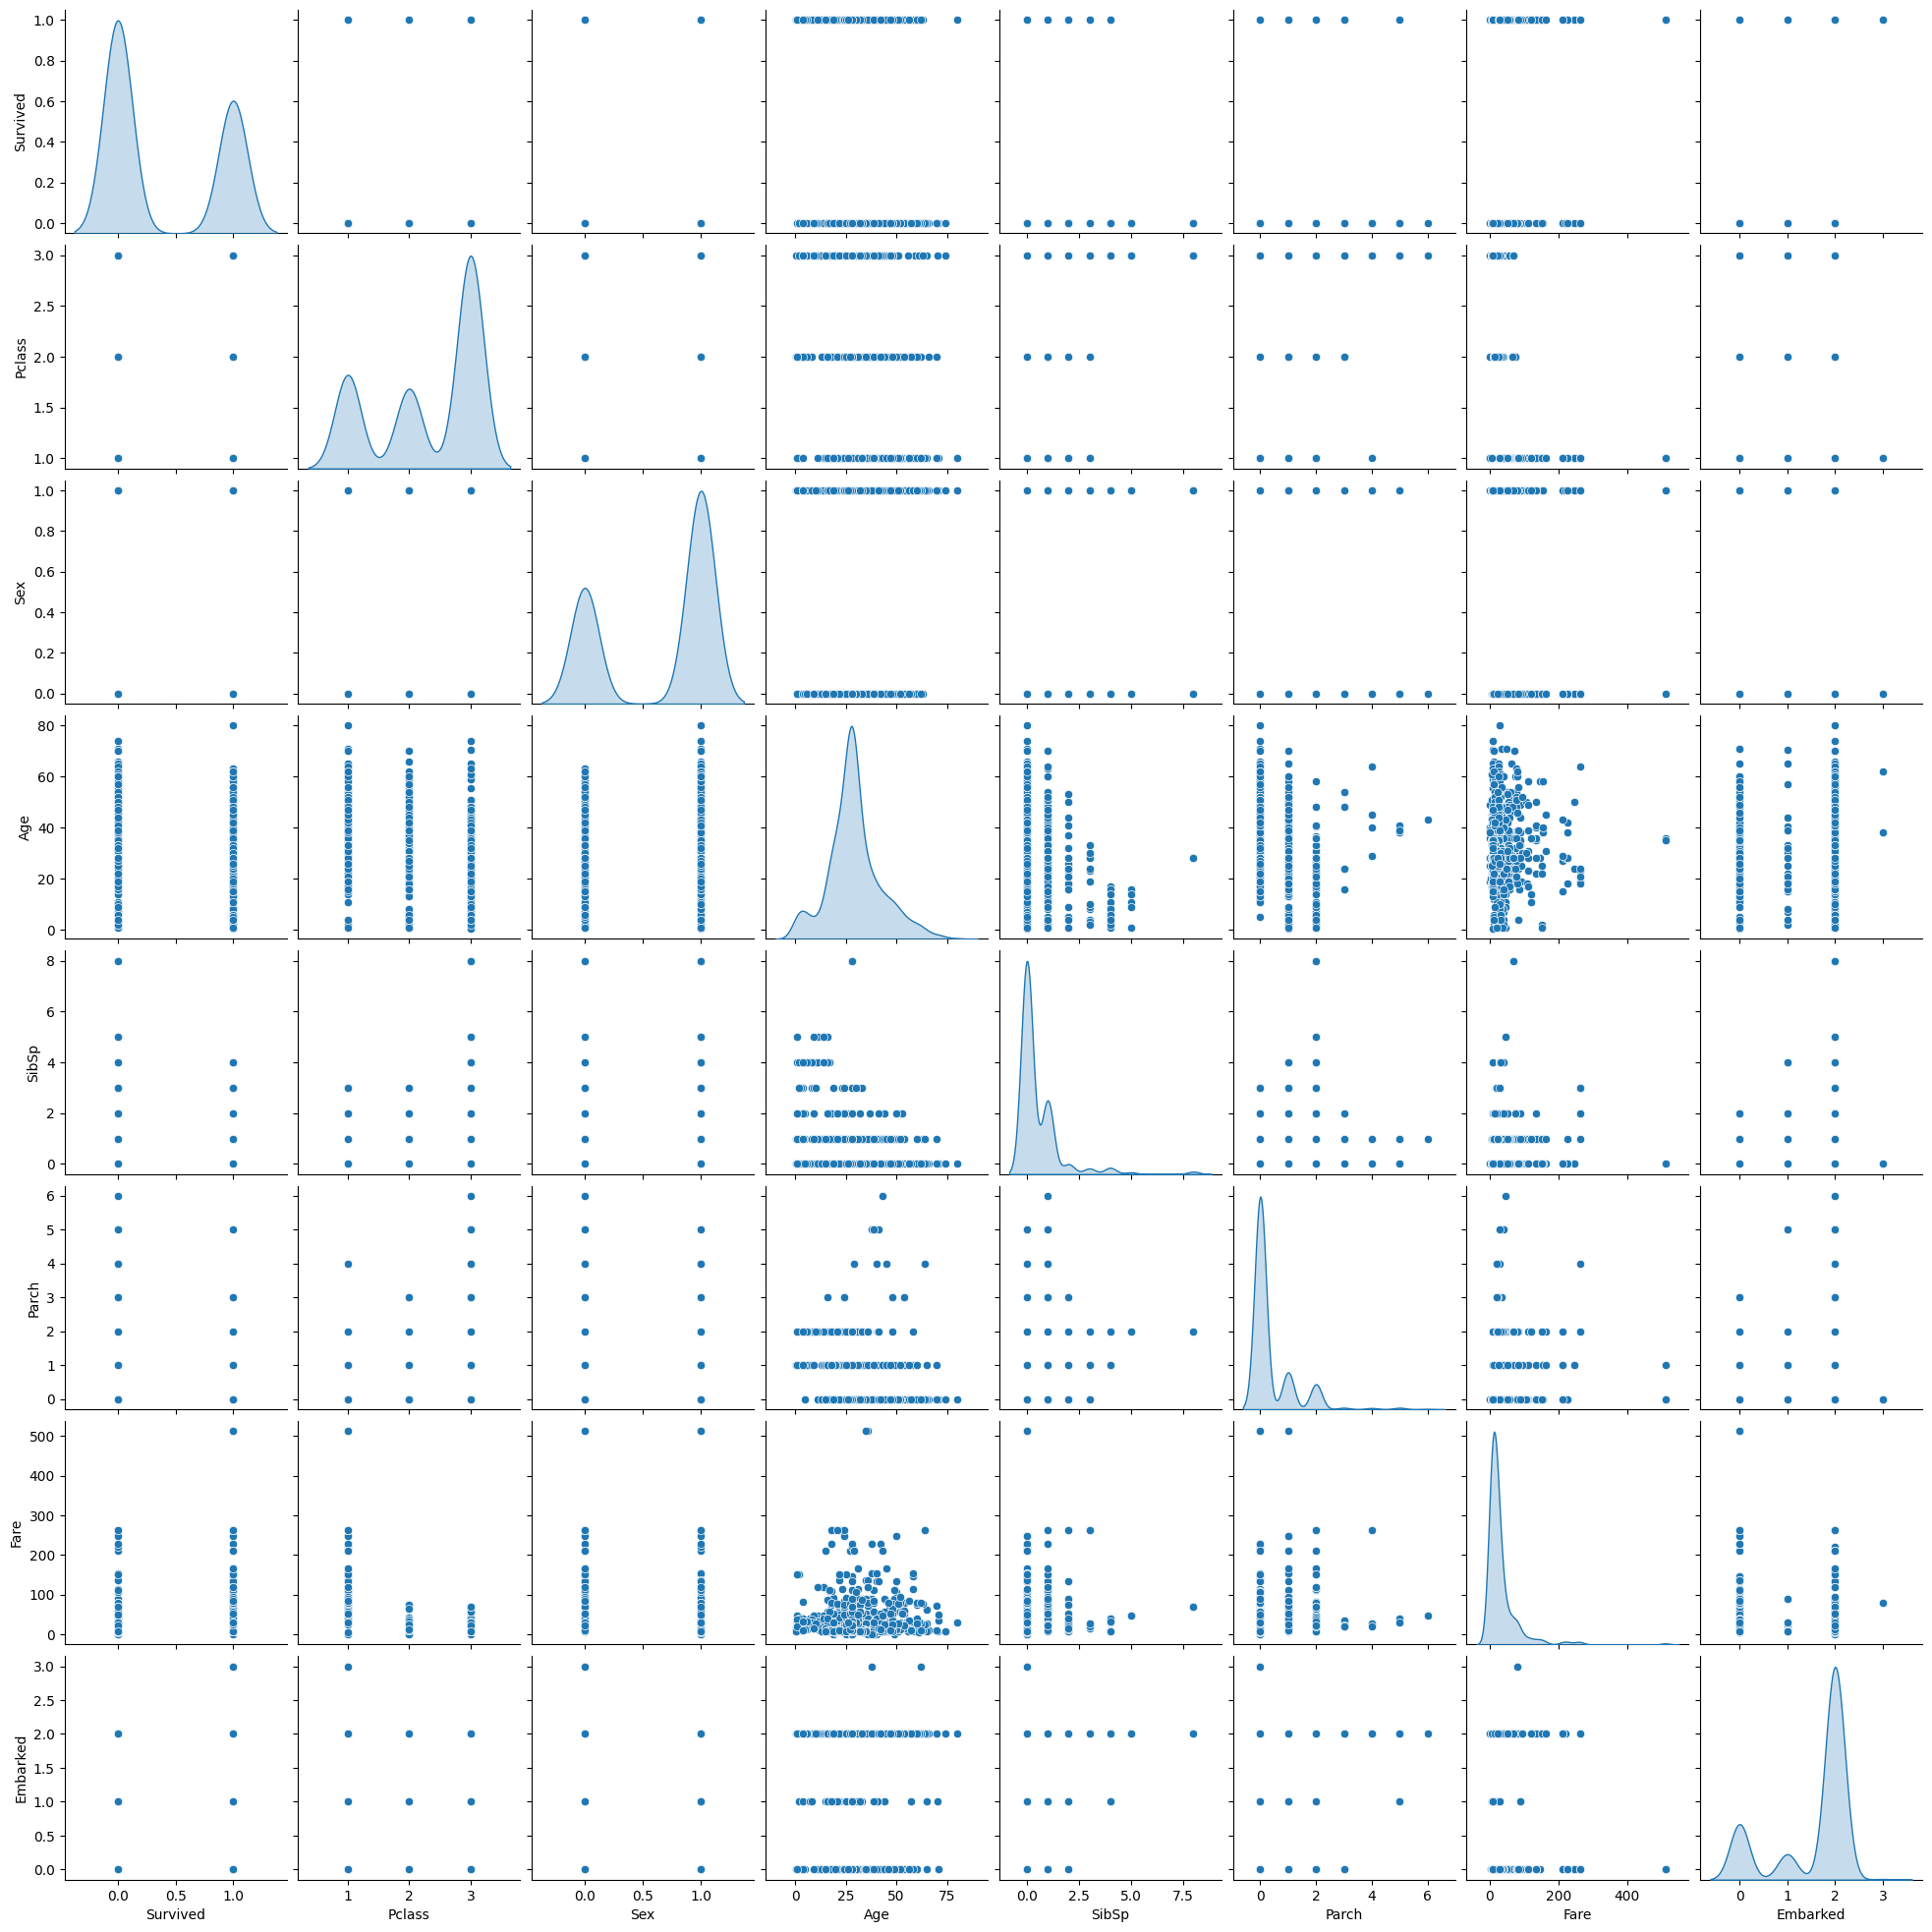

In [115]:
import seaborn as sns

sns.pairplot(df_train_clean, vars=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], diag_kind='kde')

With the diagonal distributions, we can see how the data is distributed like our bar charts above. What's interesting about the data is that it does look like Fare has some outliers. Age and SibSp look to have a small relationship based on the shape of the data. PClass and Fare also have a relationship based on the shape of the data (as should be expected).

Let's look into some survival rates as relationships to the features.

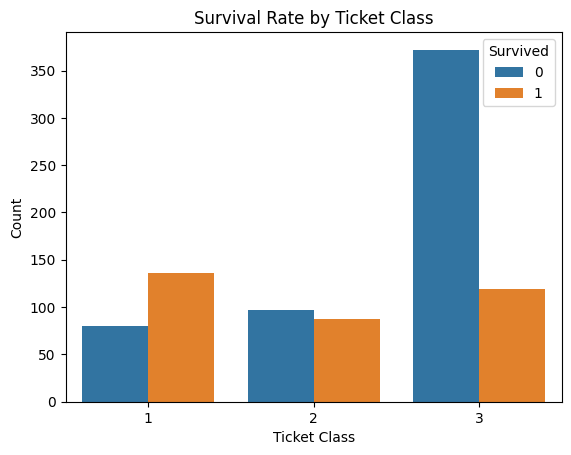

In [116]:
import seaborn as sns

sns.countplot(data=df_train_clean, x='Pclass', hue='Survived')
plt.title('Survival Rate by Ticket Class')
plt.xlabel('Ticket Class')
plt.ylabel('Count')
plt.show()

From this, we can see a correlation that PClass 3 was least likely to survive.

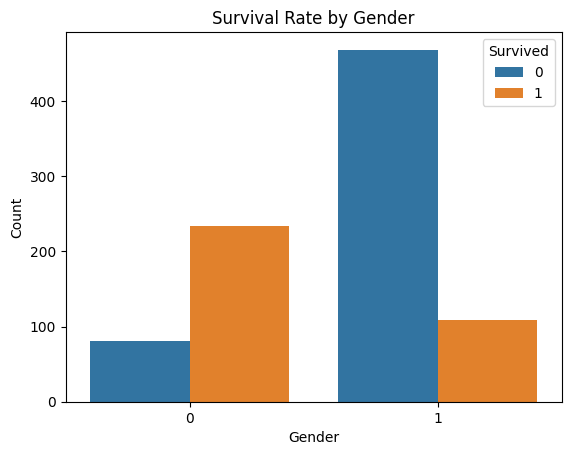

In [117]:
import seaborn as sns

sns.countplot(data=df_train_clean, x='Sex', hue='Survived')
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

It looks as if males were least likely to survive. 

Now let's split our train data into train and validation datasets. This will allow us to validate our training and do some parameter tuning before submitting to the actual test prediction dataset.

In [118]:
from sklearn.model_selection import train_test_split

X_all = df_train_clean.drop(columns=['Survived'])
y_all = df_train_clean['Survived']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2)

# Analysis (Model Building and Training)

We are going to use multiple models here. Because this is a binary classification task (survived or dead), we cannot use Simple Linear Regression or Multiple Linear Regression. The first model we will use is LogisticRegression (which is a classifier).


In [119]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(solver = 'liblinear')
model_log.fit(X_train, y_train)

y_pred_log = model_log.predict(X_test)

The next model we are going to use AdaBoost.

In [3]:
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier(n_estimators=100, random_state=42)
model_ada.fit(X_train, y_train)

y_pred_ada = model_ada.predict(X_test)

The third model we will use is SVM.

In [158]:
from sklearn.svm import SVC

model_svc = SVC()
model_svc.fit(X_train, y_train)

y_pred_svc = model_svc.predict(X_test)

# Results

For the LogisticRegression, let's get the confusion matrix. Let's get accuracy, precision, recall, and f1 (good for binary classification). As well, let's calculate the area under the curve.

Accuracy: 0.8045
Precision: 0.8594
Recall: 0.6790
F1: 0.7586


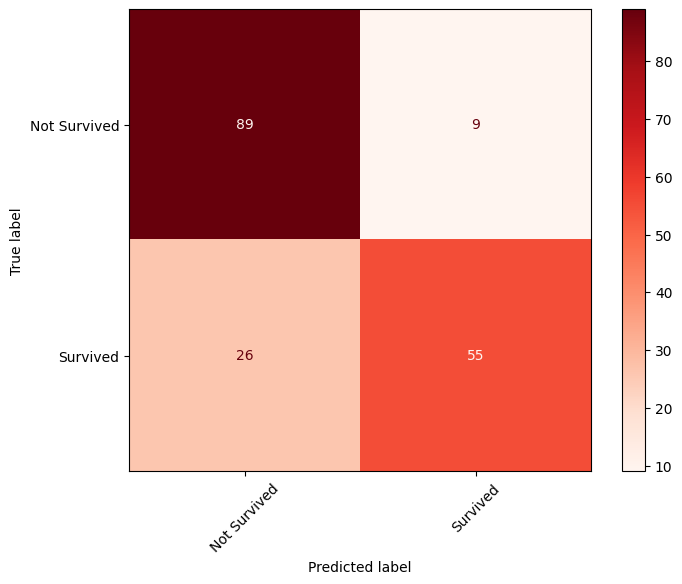

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm_log = confusion_matrix(y_test, y_pred_log)

accuracy_log = accuracy_score(y_test, y_pred_log)
precision_log = precision_score(y_test, y_pred_log)
recall_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print(f'Accuracy: {accuracy_log:.4f}')
print(f'Precision: {precision_log:.4f}')
print(f'Recall: {recall_log:.4f}')
print(f'F1: {f1_log:.4f}')

label_set = {0: 'Not Survived', 1: 'Survived'}

disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=[label_set[0], label_set[1]])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Reds", ax=ax)
plt.show()

Now, we can see the most misclassfied data was the false negative. That is, those who actually survived but the model classified them as not survived. The false positive rate is pretty low and that's why recall is lower than precision. F1 offers a balanced approach between recall and precision.

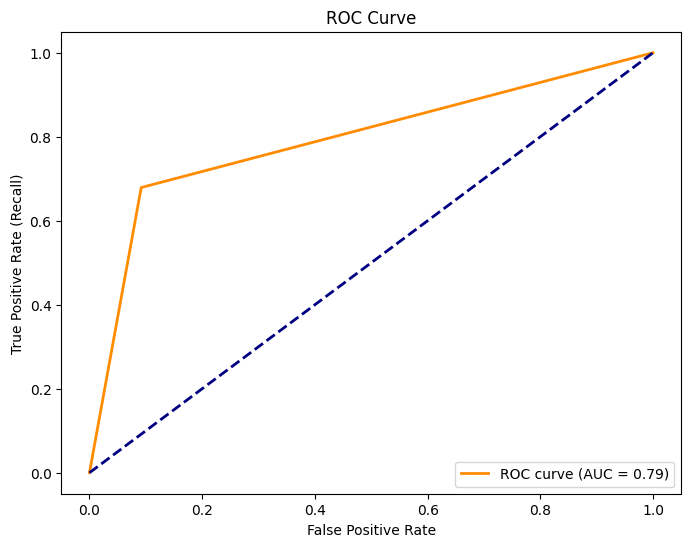

In [123]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Overall the ROC curve is above the middle line which is a good sign. The Area Under the Curve is also quite high. This highlights that Logistic Regression could be a good model and we can probably tune it a little bit.

Now let's check the results for AdaBoost

Accuracy: 0.8212
Precision: 0.8356
Recall: 0.7531
F1: 0.7922


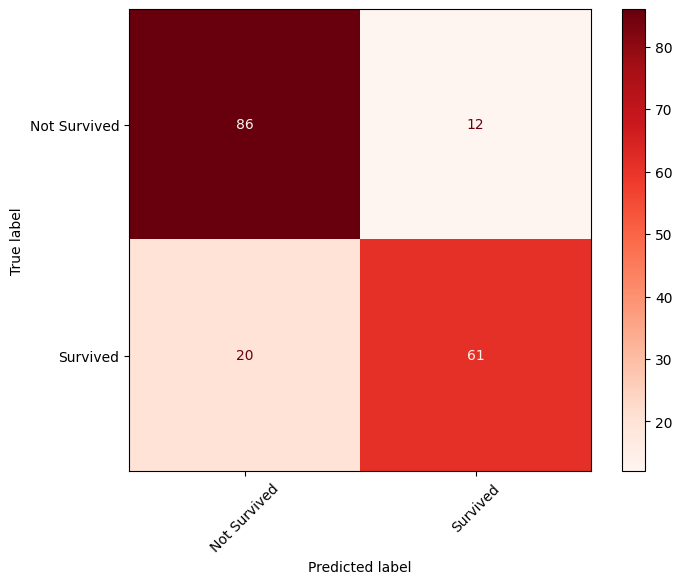

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm_ada = confusion_matrix(y_test, y_pred_ada)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

print(f'Accuracy: {accuracy_ada:.4f}')
print(f'Precision: {precision_ada:.4f}')
print(f'Recall: {recall_ada:.4f}')
print(f'F1: {f1_ada:.4f}')

label_set = {0: 'Not Survived', 1: 'Survived'}

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ada, display_labels=[label_set[0], label_set[1]])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Reds", ax=ax)
plt.show()

Now, we can see the most misclassfied data was still the false negative. That is, those who actually survived but the model classified them as not survived. The false positive rate is pretty low but higher than logistic regression. That's why recall is lower than precision again. F1 offers a balanced approach between recall and precision. This has done better than the Logistic Regression.

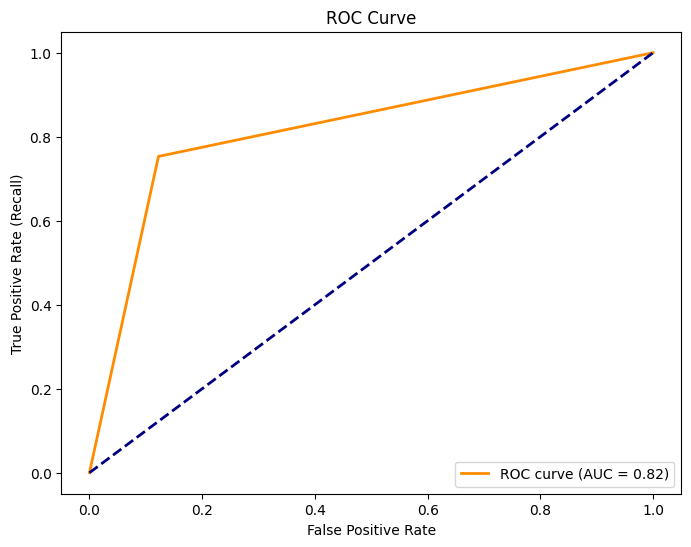

In [5]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_ada)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

From here we can see the curve is a bit higher than the curve from the Logistic Regression. The Area Under the Curve is also higher.

Now let's check the results of the SVM.

Accuracy: 0.6201
Precision: 0.7826
Recall: 0.2222
F1: 0.3462
Cross-val mean-accuracy: 0.678


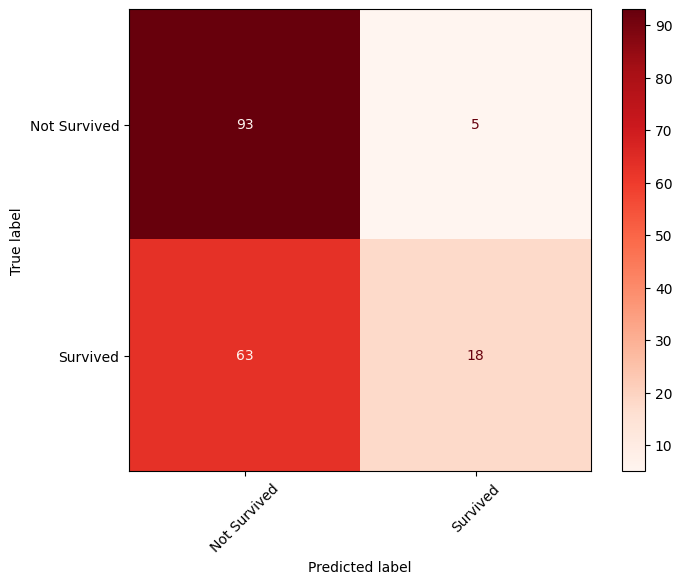

In [159]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

cm_svc = confusion_matrix(y_test, y_pred_svc)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

print(f'Accuracy: {accuracy_svc:.4f}')
print(f'Precision: {precision_svc:.4f}')
print(f'Recall: {recall_svc:.4f}')
print(f'F1: {f1_svc:.4f}')

scores = cross_val_score(model_svc, X_train, y_train)
print("Cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

label_set = {0: 'Not Survived', 1: 'Survived'}

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=[label_set[0], label_set[1]])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Reds", ax=ax)
plt.show()

We can see from this that the SVM had trouble with the false negatives but did better with false positives than the other two models. Overall, from the scores it doesn't seem like this would be a good model choice to continue with.

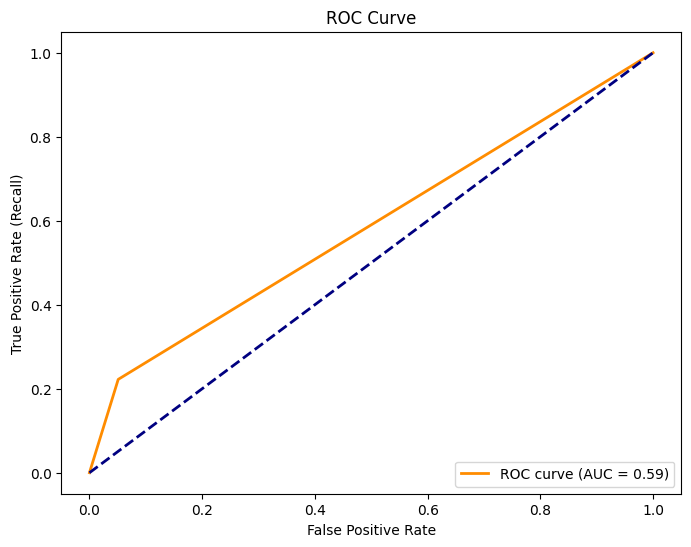

In [128]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The curve is only just above the middle line. This indicates that it probably isn't the right model for this dataset right now.

# Tuning

From the three models (without any tuning), we can see that AdaBoost and LogisticRegression perform fairly similar. However, AdaBoost has the larger F1 Score. I will perform some tuning on both models to see which has the better performance.

**AdaBoost**

The hyper parameters we will tune are the number of estimators (n_estimators) and the learning rate.

* **n_estimators:** The default is 50. This is the max number of estimators before the boosting is terminated.
* **learning_rate:** A higher learning rate increases the contribution of each classifier.

We will use f1 scoring due to being one of the best choices for comparing binary classification problems.

In [6]:
from sklearn.model_selection import GridSearchCV

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

param_dist = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_dist, scoring='f1')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_ada = grid_search.best_estimator_
y_pred_best_ada = best_ada.predict(X_test)

accuracy_best_ada = accuracy_score(y_test, y_pred_best_ada)
precision_best_ada = precision_score(y_test, y_pred_best_ada)
recall_best_ada = recall_score(y_test, y_pred_best_ada)
f1_best_ada = f1_score(y_test, y_pred_best_ada)

print(f'Accuracy: {accuracy_best_ada:.4f}')
print(f'Precision: {precision_best_ada:.4f}')
print(f'Recall: {recall_best_ada:.4f}')
print(f'F1: {f1_best_ada:.4f}')

Best parameters: {'learning_rate': 1, 'n_estimators': 50}
Accuracy: 0.8268
Precision: 0.8571
Recall: 0.7407
F1: 0.7947


Compared to the AdaBoost original model F1 score (0.7922), this has performed slightly better.

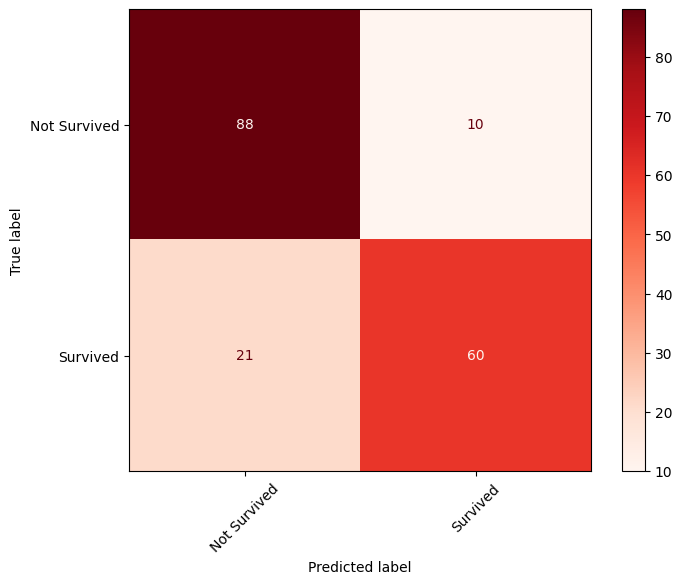

In [7]:
label_set = {0: 'Not Survived', 1: 'Survived'}

cm_best_ada = confusion_matrix(y_test, y_pred_best_ada)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_ada, display_labels=[label_set[0], label_set[1]])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Reds", ax=ax)
plt.show()

The false positive has gone down from 12 to 10. However, the false negative has increased from 20 to 21. The tuning didn't really produce something significantly different.

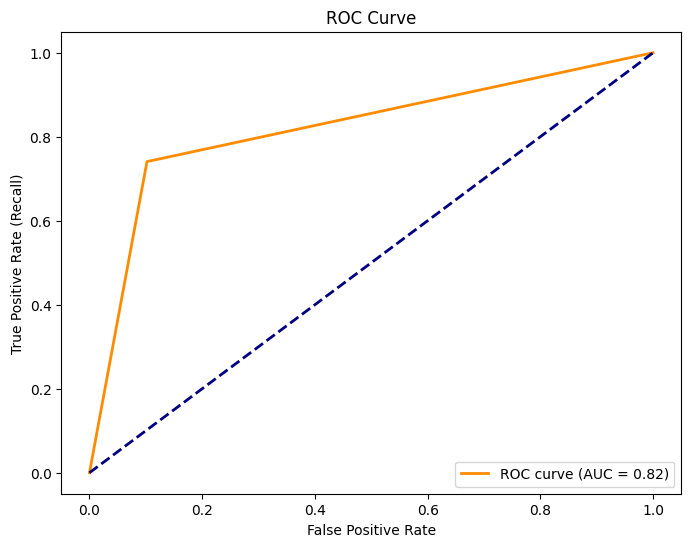

In [8]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_ada)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Looking at the ROC curve, it is pretty good (it's above the baseline) by a significant margin. 

Let's create the test predictions and get ready to submit. Note: this section is explicitly commented out as I only need it to submit to the kaggle competition. The score from the competition is on the last line.

In [134]:
#y_pred_output = best_ada.predict(df_test_clean)

#df_predictions = pd.DataFrame({
#    'PassengerId': df_test['PassengerId'],
#    'Survived': y_pred_output
#})

#df_predictions.to_csv('submission.csv', index=False)
# Score: 0.76315

**Logistic Regression**

Next, we want to do a quick hyperparameter tuning for the LogisticRegression. The hyperparameters we will change are C, solver, and penalty. We'll also change the cap of the max iterations to 1000.

* **C:** Probably the most important parameter to change. It's the inverse of regulization (i.e. smaller values will mean more regularization). I've chosen a range of values from small to large for C to allow the GridSearchCV to compare.
* **solver:** I've chosen three solvers that work with binary classification problems (and this is a pretty small dataset). 
* **penalty:** There are two penalties - l1 and l2.

We will use f1 scoring due to being one of the best choices for comparing binary classification problems.

In [140]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'newton-cholesky'],
    'penalty': ['l1', 'l2'],
    'max_iter': [1000]
}

grid_search_log = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='f1')
grid_search_log.fit(X_train, y_train)

print("Best parameters:", grid_search_log.best_params_)

best_log = grid_search_log.best_estimator_
y_pred_best_log = best_log.predict(X_test)

accuracy_best_log = accuracy_score(y_test, y_pred_best_log)
precision_best_log = precision_score(y_test, y_pred_best_log)
recall_best_log = recall_score(y_test, y_pred_best_log)
f1_best_log = f1_score(y_test, y_pred_best_log)

print(f'Accuracy: {accuracy_best_log:.4f}')
print(f'Precision: {precision_best_log:.4f}')
print(f'Recall: {recall_best_log:.4f}')
print(f'F1: {f1_best_log:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Accuracy: 0.8045
Precision: 0.8833
Recall: 0.6543
F1: 0.7518


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.f

What's interesting here is the amount of non-convergence. As well, the F1 score is lower than our original model (0.7586 vs 0.7518).

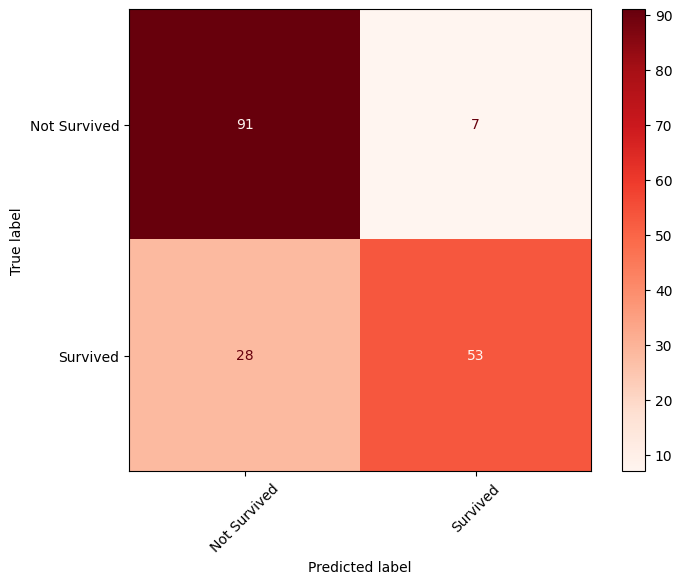

In [141]:
label_set = {0: 'Not Survived', 1: 'Survived'}

cm_best_log = confusion_matrix(y_test, y_pred_best_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_log, display_labels=[label_set[0], label_set[1]])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Reds", ax=ax)
plt.show()

We can see this by the false positives decreasing from 9 to 7. However, the false negatives increased from 26 to 28. It's interesting that both the Logistic Regression and AdaBoost followed a similar pattern.

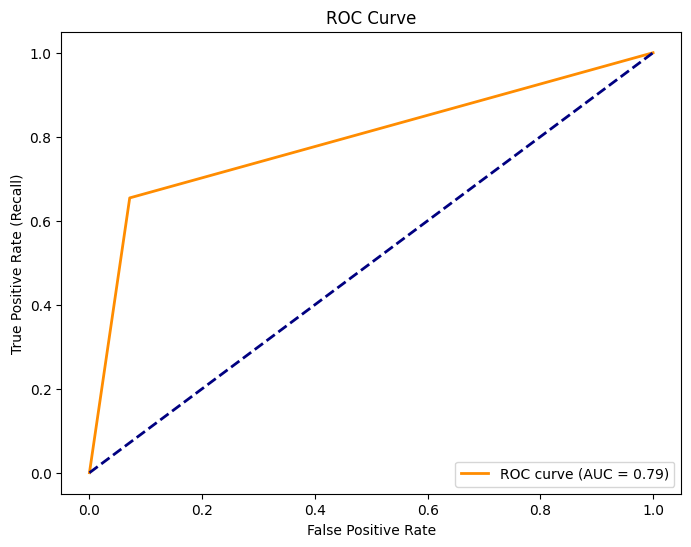

In [142]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_log)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Looking at the ROC curve, it is pretty good (it's above the baseline) by a significant margin but it's not as good as the ROC from the AdaBoost.

Let's create the test predictions and get ready to submit. Note: this section is explicitly commented out as I only need it to submit to the kaggle competition. The score from the competition is on the last line.

In [ ]:
#y_pred_output = best_log.predict(df_test_clean)

#df_predictions = pd.DataFrame({
#    'PassengerId': df_test['PassengerId'],
#    'Survived': y_pred_output
#})

#df_predictions.to_csv('submission.csv', index=False)
# Score: 0.76555

# Conclusion

In [9]:
performance_data = {
    'Model': ['Logistic Regression', 'AdaBoost', 'SVC', 'Best Logistic Regression', 'Best AdaBoost'],
    'Accuracy': [accuracy_log, accuracy_ada, accuracy_svc, accuracy_best_log, accuracy_best_ada],
    'F1 Score': [f1_log, f1_ada, f1_svc, f1_best_log, f1_best_ada],
    'Recall': [recall_log, recall_ada, recall_svc, recall_best_log, recall_best_ada],
    'Precision': [precision_log, precision_ada, precision_svc, precision_best_log, precision_best_ada]
}

# Convert the dictionary into a DataFrame
df_performance = pd.DataFrame(performance_data).sort_values(by=['Accuracy', 'F1 Score'], ascending=False)
df_performance

,Model,Accuracy,F1 Score,Recall,Precision
4,Best AdaBoost,0.826816,0.794702,0.740741,0.857143
1,AdaBoost,0.821229,0.792208,0.753086,0.835616
0,Logistic Regression,0.804469,0.758621,0.679012,0.859375
3,Best Logistic Regression,0.804469,0.751773,0.654321,0.883333
2,SVC,0.620112,0.346154,0.222222,0.782609


From the table above, we can clearly see that AdaBoost and Logistic Regression are pretty close. The Hyperparameter tuning didn't really change much for our models (for the the Logistic Regression it made the F1 score worse). We can also see that for the Logistics Regression, a lot of the models didn't reach convergence.

We can also see, from the earlier submissions, that the actual test data returned an accuracy of 0.76315 for the AdaBoost and 0.76555 for the Logistic Regression. This shows that the AdaBoost may have been overfitting on the train data. Logistic Regression also has some overfitting (0.804469 to 0.76555) but not as big a drop as the AdaBoost (0.826816 to 0.76315).

Looking back at the Area under the Curve for the Receiver Operating Characteristic curve, the AdaBoost performed better with 0.82 compared to the Logistic regression at 0.79. The difference is not that significant though.

What's interesting is that the SVM performed poorly compared to the AdaBoost and the Logistic Regression. This could be because I didn't normalize any of the data (so there may be sensitivity to the scale of features) and I haven't performed any feature selection which could lead to complex models.

Overall, I think the models are satisfying. They give a relatively good performance but still have room for improvement. Most of the improvement may come from different model selection, feature selection, or even more data preprocessing (such as normalization) which may lead to better results.

**References:**

https://www.kaggle.com/code/alexandermaitken/week-4-part-1-bbc-news-classification

https://scikit-learn.org/stable/modules/model_evaluation.html#binary-classification

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html